In [74]:

import pandas as pd
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Data Preporeocessing and Feature Extraction


In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from pandas.tseries.offsets import DateOffset

# Fetch the stock data
tickerSymbol = 'AAPL'
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period='1d', start='2018-8-1', end='2019-1-31')

# Calculate the technical indicators
df['Turnover'] = df['Volume'] * df['Close']
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Line'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']
TP = (df['High'] + df['Low'] + df['Close']) / 3
df['SMA_TP_20'] = TP.rolling(window=20).mean()
MD = lambda x: np.mean(np.abs(x - np.mean(x)))
df['Mean_Deviation'] = TP.rolling(window=20).apply(MD, raw=True)
df['CCI'] = (TP - df['SMA_TP_20']) / (0.015 * df['Mean_Deviation'])
Lowest_Low = df['Low'].rolling(window=14).min()
Highest_High = df['High'].rolling(window=14).max()
df['%K'] = 100 * (df['Close'] - Lowest_Low) / (Highest_High - Lowest_Low)
df['%D'] = df['%K'].rolling(window=3).mean()
df['21ROC'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)) * 100
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))
df['PVT'] = (df['Close'].diff() / df['Close'].shift()) * df['Volume']
df['PVT'] = df['PVT'].fillna(0).cumsum()
df['Typical'] = (df['High'] + df['Low'] + df['Close']) / 3

# Preprocess the data
X = df.drop('Close', axis=1).dropna()
X = df[['MACD_Line', 'CCI', '%K', '%D', '21ROC', 'RSI', 'PVT', 'Turnover', 'Typical']].dropna()
y = df.loc[X.index, 'Close']
y = df.loc[X.index, 'Close']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Define the base regressors



# MetaRegressor using ExtraTrees

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


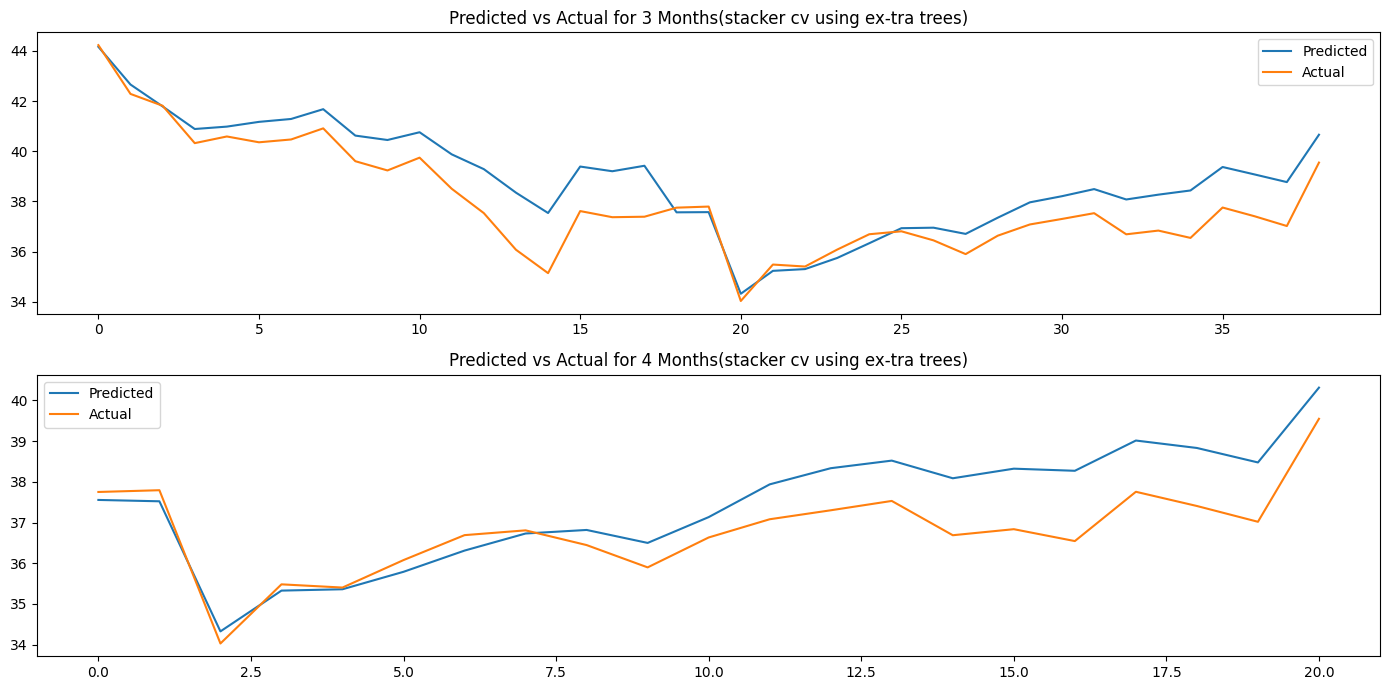

In [76]:
svm = SVR(kernel='linear', gamma=1e-8, epsilon=0.001)
extra_trees = ExtraTreesRegressor(n_estimators=250, random_state=1)

# Define the meta regressor
stack = StackingCVRegressor(regressors=(svm, extra_trees),
                            meta_regressor=svm,
                            use_features_in_secondary=True)

# Define the training periods in months
training_periods = [3, 4, 5]

# Initialize lists to store R2 and RMSE values for each training period
r2_scores = []
rmse_scores = []
# Initialize lists to store predicted and actual values for 3 and 4 months
preds_3m = []
actuals_3m = []
preds_4m = []
actuals_4m = []

for months in training_periods:
    train_start = X_scaled_df.index.min()
    train_end = train_start + DateOffset(months=months)

    while train_end < X_scaled_df.index.max():
        X_train_cv = X_scaled_df.loc[train_start:train_end]
        y_train_cv = y.loc[train_start:train_end]
        X_test_cv = X_scaled_df.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]
        y_test_cv = y.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]

        stack.fit(X_train_cv, y_train_cv)
        y_pred_cv = stack.predict(X_test_cv)

        # Store predicted and actual values for 3 and 4 months
        if months == 3:
            preds_3m.extend(y_pred_cv)
            actuals_3m.extend(y_test_cv)
        elif months == 4:
            preds_4m.extend(y_pred_cv)
            actuals_4m.extend(y_test_cv)

        rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))

        train_start += DateOffset(months=1)
        train_end += DateOffset(months=1)

# Plot predicted vs actual for 3 and 4 months
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(preds_3m, label='Predicted')
plt.plot(actuals_3m, label='Actual')
plt.title('Predicted vs Actual for 3 Months(stacker cv using ex-tra trees)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(preds_4m, label='Predicted')
plt.plot(actuals_4m, label='Actual')
plt.title('Predicted vs Actual for 4 Months(stacker cv using ex-tra trees)')
plt.legend()

plt.tight_layout()
plt.show()


# Comparison with Standard SVM

<Figure size 1000x500 with 0 Axes>

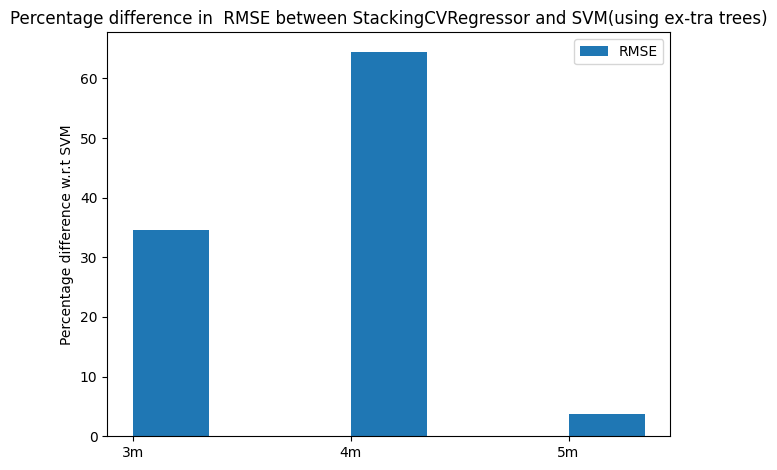

In [77]:
# Initialize lists to store R2 and RMSE values for the standard SVM
rmse_scores_svm = []

# Perform time series cross-validation for each training period
for months in training_periods:
    # Define the start and end of the training period
    train_start = X_scaled_df.index.min()
    train_end = train_start + DateOffset(months=months)

    # Continue looping until the end of the training set is reached
    while train_end < X_scaled_df.index.max():
        # Define the training and testing data for this split
        X_train_cv = X_scaled_df.loc[train_start:train_end]
        y_train_cv = y.loc[train_start:train_end]
        X_test_cv = X_scaled_df.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]
        y_test_cv = y.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]

        # Fit the SVM on the training data and make predictions on the test data
        svm.fit(X_train_cv, y_train_cv)
        y_pred_cv_svm = svm.predict(X_test_cv)

        # Calculate R2 and RMSE for this split
        # r2_scores_svm.append(r2_score(y_test_cv, y_pred_cv_svm))
        rmse_scores_svm.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv_svm)))

        # Move the training period forward by one month
        train_start += DateOffset(months=1)
        train_end += DateOffset(months=1)
# print()
# print()
# print(len(r2_scores_svm))
# print(len(rmse_scores_svm))
# print()
# print()

# r2_diff = [(i - j) / j * 100 for i, j in zip(r2_scores, r2_scores_svm)]
rmse_diff = [(i - j) / j * 100 for i, j in zip(rmse_scores, rmse_scores_svm)]


plt.figure(figsize=(10, 5))
width = 0.35
labels = ['3m', '4m', '5m']
x = np.arange(len(labels))
fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, r2_diff, width, label='R2')
rects2 = ax.bar(x + width/2, rmse_diff, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage difference w.r.t SVM')
ax.set_title('Percentage difference in  RMSE between StackingCVRegressor and SVM(using ex-tra trees)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()



#MetaRregressor using Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


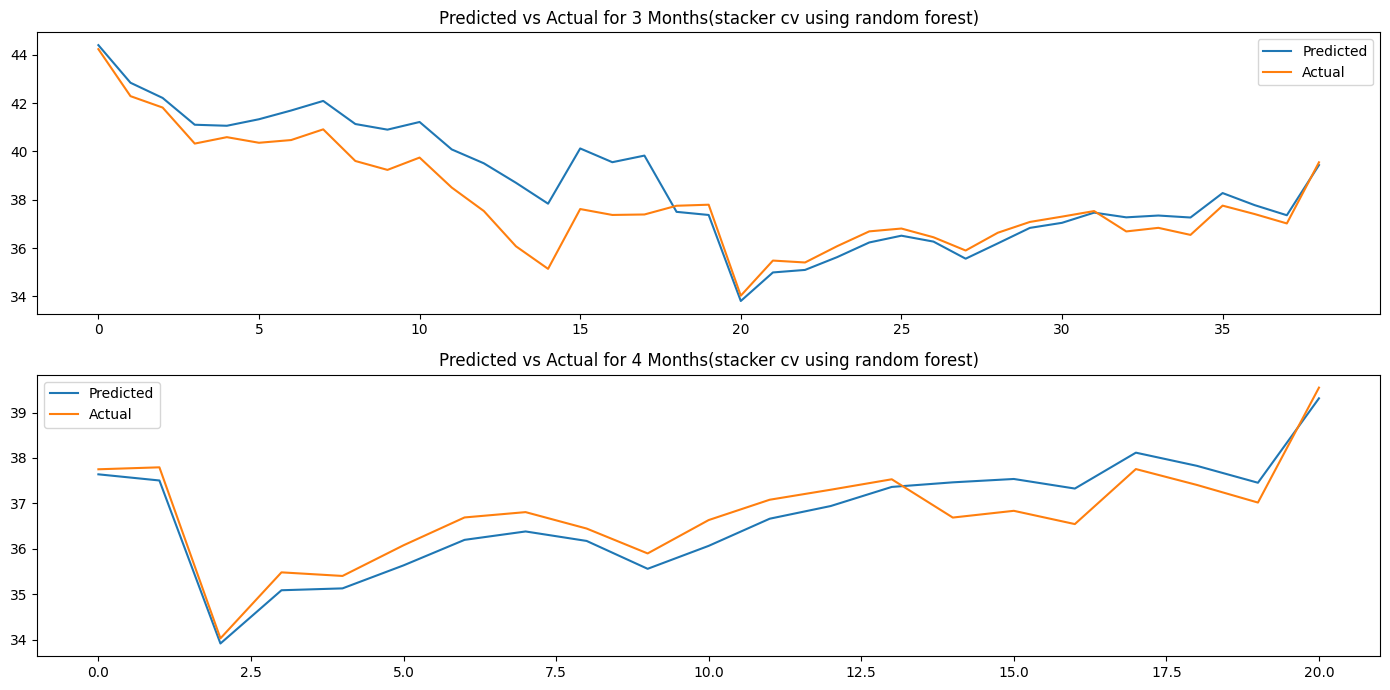

In [78]:

# Define the base regressors
svm = SVR(kernel='linear', gamma=1e-8, epsilon=0.001)
random_forest = RandomForestRegressor(n_estimators=250, random_state=10)

# Define the meta regressor
stack = StackingCVRegressor(regressors=(svm, random_forest),
                            meta_regressor=svm,
                            use_features_in_secondary=True)

# Define the training periods in months
training_periods = [3, 4, 5]

# Initialize lists to store R2 and RMSE values for each training period
r2_scores = []
rmse_scores = []
preds_3m = []
actuals_3m = []
preds_4m = []
actuals_4m = []

for months in training_periods:
    train_start = X_scaled_df.index.min()
    train_end = train_start + DateOffset(months=months)

    while train_end < X_scaled_df.index.max():
        X_train_cv = X_scaled_df.loc[train_start:train_end]
        y_train_cv = y.loc[train_start:train_end]
        X_test_cv = X_scaled_df.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]
        y_test_cv = y.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]

        stack.fit(X_train_cv, y_train_cv)
        y_pred_cv = stack.predict(X_test_cv)

        # Store predicted and actual values for 3 and 4 months
        if months == 3:
            preds_3m.extend(y_pred_cv)
            actuals_3m.extend(y_test_cv)
        elif months == 4:
            preds_4m.extend(y_pred_cv)
            actuals_4m.extend(y_test_cv)

        rmse_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))

        train_start += DateOffset(months=1)
        train_end += DateOffset(months=1)

# Plot predicted vs actual for 3 and 4 months
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(preds_3m, label='Predicted')
plt.plot(actuals_3m, label='Actual')
plt.title('Predicted vs Actual for 3 Months(stacker cv using random forest)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(preds_4m, label='Predicted')
plt.plot(actuals_4m, label='Actual')
plt.title('Predicted vs Actual for 4 Months(stacker cv using random forest)')
plt.legend()

plt.tight_layout()
plt.show()





# Comparisison with standard SVM




<Figure size 1000x500 with 0 Axes>

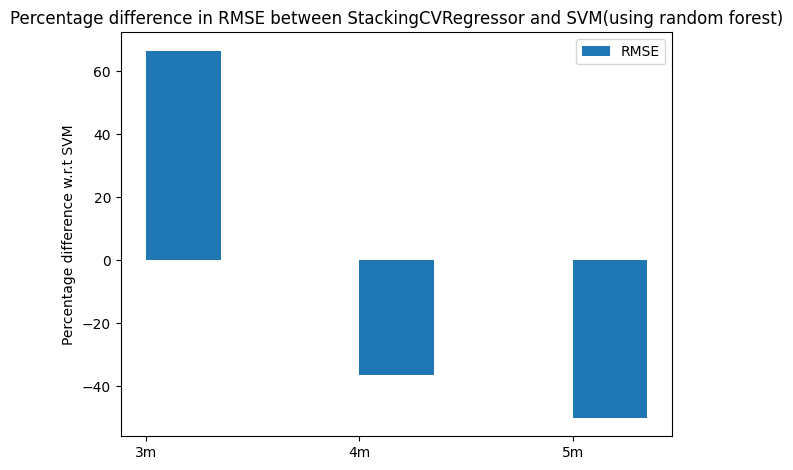

In [79]:
# Initialize lists to store R2 and RMSE values for the standard SVM
rmse_scores_svm = []

# Perform time series cross-validation for each training period
for months in training_periods:
    # Define the start and end of the training period
    train_start = X_scaled_df.index.min()
    train_end = train_start + DateOffset(months=months)

    # Continue looping until the end of the training set is reached
    while train_end < X_scaled_df.index.max():
        # Define the training and testing data for this split
        X_train_cv = X_scaled_df.loc[train_start:train_end]
        y_train_cv = y.loc[train_start:train_end]
        X_test_cv = X_scaled_df.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]
        y_test_cv = y.loc[train_end + DateOffset(days=1):train_end + DateOffset(months=1)]

        # Fit the SVM on the training data and make predictions on the test data
        svm.fit(X_train_cv, y_train_cv)
        y_pred_cv_svm = svm.predict(X_test_cv)

        # Calculate R2 and RMSE for this split
        # r2_scores_svm.append(r2_score(y_test_cv, y_pred_cv_svm))
        rmse_scores_svm.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv_svm)))

        # Move the training period forward by one month
        train_start += DateOffset(months=1)
        train_end += DateOffset(months=1)

# r2_diff = [(i - j) / j * 100 for i, j in zip(r2_scores, r2_scores_svm)]
rmse_diff = [(i - j) / j * 100 for i, j in zip(rmse_scores, rmse_scores_svm)]

plt.figure(figsize=(10, 5))
width = 0.35
labels = ['3m', '4m', '5m']
x = np.arange(len(labels))
fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, r2_diff, width, label='R2')
rects2 = ax.bar(x + width/2, rmse_diff, width, label='RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage difference w.r.t SVM')
ax.set_title('Percentage difference in RMSE between StackingCVRegressor and SVM(using random forest)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()